# Image tensors

A coffee company has an object detection project where they need to annotate objects of interest, in this case, espresso shots. You have created a list with the bounding box coordinates for an espresso shot image. Now, you need to convert the image and the coordinates into tensors.

But lets use the same dog and cat classifcition dataset

* Convert the bbox into tensors using torch.tensor().
* Reshape bbox_tensor by adding a batch dimension using unsqueeze(0).
* Create a transform to resize image to (224) and transform to an unscaled image tensor.
* Apply transform to image.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim

**Resize to 512*512**

In [6]:
import os
from PIL import Image

# Directory containing the images
image_dir = '/kaggle/input/cats-and-dogs-image-classification/train/dogs'
output_dir = '/kaggle/working/resized_dog_images'  # Directory to save resized images

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Resize dimensions
resize_dimensions = (512, 512)

# Iterate through the images in the directory
for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
        with Image.open(image_path) as image:
            # Resize the image
            resized_image = image.resize(resize_dimensions)

            # Save the resized image to the output directory
            resized_image_path = os.path.join(output_dir, image_name)
            resized_image.save(resized_image_path)

print(f"Resized and saved {image_name} to {resized_image_path}")
         

Resized and saved dog_418.jpg to /kaggle/working/resized_dog_images/dog_418.jpg


In [33]:
# Example bounding box coordinates
bbox = [25, 25, 200, 200]  # Replace with actual coordinates

# # Convert bbox into tensors
# bbox_tensor = torch.tensor(bbox, dtype=torch.float32)

# # Add a new batch dimension
# bbox_tensor = bbox_tensor.unsqueeze(0)

# Load the image
image_path = '/kaggle/working/resized_dog_images/dog_216.jpg'  # Replace with your image path
image = Image.open(image_path).convert("RGB")


In [30]:
# Convert bbox into tensors
bbox_tensor = torch.tensor(bbox)

# Add a new batch dimension
bbox_tensor = bbox_tensor.unsqueeze(0)

# Resize the image and transform to tensor
transform = transforms.Compose([
  transforms.Resize(224),
   transforms.PILToTensor()
])

# Apply transform to image
image_tensor = transform(image)
print(image_tensor)

tensor([[[161, 158, 154,  ..., 255, 255, 255],
         [154, 159, 154,  ..., 255, 255, 255],
         [161, 156, 155,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[139, 138, 137,  ..., 255, 255, 255],
         [132, 139, 137,  ..., 255, 255, 255],
         [142, 137, 138,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[119, 115, 110,  ..., 255, 255, 255],
         [113, 116, 111,  ..., 255, 255, 255],
         [123, 116, 116,  ..., 255, 255, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)


Usually, we use transforms.ToTensor() float transformation for images to scale them in the range [0,1]. However, the bounding box requires an unscaled image type with the range [0, 255], so we use transforms.PILToTensor().

In [31]:
image_tensor.type()

'torch.ByteTensor'

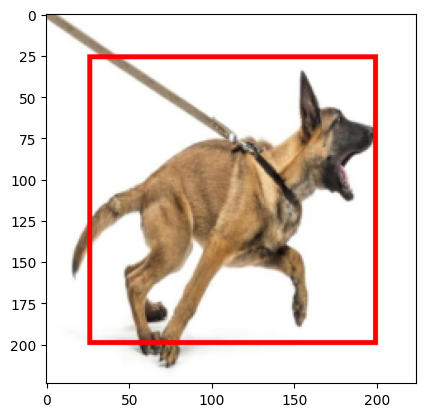

In [34]:
# Import draw_bounding_boxes
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

x_min, y_min, x_max, y_max = 25, 25, 200, 200
# Define the bounding box coordinates
bbox = [x_min, y_min, x_max, y_max]
bbox_tensor = torch.tensor(bbox).unsqueeze(0)

# Implement draw_bounding_boxes
img_bbox = draw_bounding_boxes(image_tensor, bbox_tensor, width=3, colors="red")

# Tranform tensors to image
transform = transforms.Compose([
   transforms.ToPILImage()
])
plt.imshow(transform(img_bbox))
plt.show()

**Intersection of Union in Pytorch(IoU)**

In [5]:
bbox1 = [50,50, 150, 150]
bbox2 = [100, 100, 200, 200]
bbox3 = [150, 150, 450, 450]

bbox1 = torch.tensor(bbox1).unsqueeze(0)
bbox2 = torch.tensor(bbox2).unsqueeze(0)
bbox3 = torch.tensor(bbox3).unsqueeze(0)

print(bbox1)

tensor([[ 50,  50, 150, 150]])


In [7]:
from torchvision.ops import box_iou

iou1 = box_iou(bbox1,bbox2)
print(iou1)

iou2 = box_iou(bbox2,bbox3)
print(iou2)

iou3 = box_iou(bbox3,bbox1)
print(iou3)

tensor([[0.1429]])
tensor([[0.0256]])
tensor([[0.]])


# Bounding boxes prediction

You have trained an object recognition model. Now, you want to use to generate bounding boxes and classifications for a test image.

 The test_image is also available, and torch and torch.nn as nn have been imported.

Lets define a dummy model1


In [9]:
class ObjectDetectionModel(nn.Module):
    def __init__(self):
        super(ObjectDetectionModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 5)  # Assuming 5 classes
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Bounding box coordinates
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        class_scores = self.classifier(x)
        bboxes = self.bbox_regressor(x)
        return {'boxes': bboxes, 'scores': class_scores}

Generate Dummy Data

In [11]:
from torch.utils.data import Dataset, DataLoader

class DummyDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.images = torch.randn(num_samples, 3, 32, 32)  # Random images
        self.bboxes = torch.rand(num_samples, 4)  # Random bounding boxes
        self.scores = torch.randint(0, 5, (num_samples,))  # Random class scores

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.bboxes[idx], self.scores[idx]

train_dataset = DummyDataset(num_samples=100)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


Train the Model

In [13]:
model = ObjectDetectionModel()
criterion_bbox = nn.MSELoss()
criterion_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(5):  # Training for 5 epochs
    for images, bboxes, scores in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss_bbox = criterion_bbox(outputs['boxes'], bboxes)
        loss_class = criterion_class(outputs['scores'], scores)
        loss = loss_bbox + loss_class
        loss.backward()
        optimizer.step()

print("Training complete")

Training complete


In [18]:
model.eval()
with torch.no_grad():
    test_image = torch.randn(1, 3, 32, 32)  # Dummy test image
    outputs = model(test_image)

boxes = outputs['boxes']
scores = torch.softmax(outputs['scores'], dim=1)  # Apply softmax to get probabilities
_, scores = torch.max(scores, 1)  # Get the class with the highest score

print(boxes, scores)


tensor([[0.5391, 0.4128, 0.6017, 0.5215]]) tensor([3])


In [15]:
# test_image = "/kaggle/input/cats-and-dogs-image-classification/train/dogs/dog_0.jpg"

model.eval()
# Get model's prediction
with torch.no_grad():
    output = model(test_image)

# Extract boxes from the output
boxes = output[0]["boxes"]
# Extract scores from the output
scores = output[0]["scores"]

print(boxes, scores)

TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


<script.py> output:

    tensor([[0.6455, 0.1786, 0.9680, 0.6124],
            [0.6209, 0.3425, 0.0394, 0.9515],
            [0.5825, 0.7270, 0.8606, 0.9858],
            [0.1787, 0.3474, 0.9625, 0.4668],
            [0.5990, 0.5499, 0.7973, 0.6566]]) tensor([0.7801, 0.8328, 0.8765, 0.9900, 0.8696])

Predicted box coordinates and their confidence scores are important values for understanding how the model is performing.

**Calculate NMS**

Having extracted the predicted bounding boxes and scores from your object recognition model, your next task is to ensure that only the most accurate and non-overlapping predicted bounding boxes are retained by using the non-max suppression technique.

boxes and scores you created in the previous exercise are available in your workspace and torch and torchvision have been imported.

* Import nms from torchvision.ops.
* Set the IoU threshold to be equal 0.5.
* Apply non-max suppression passing boxes, confidence_scores, and iou_threshold to the relevant function.
* Use the output indices to filter predicted boxes.

In [19]:
# Simulate the outputs for demonstration purposes
boxes = torch.tensor([
    [0.6455, 0.1786, 0.9680, 0.6124],
    [0.6209, 0.3425, 0.0394, 0.9515],
    [0.5825, 0.7270, 0.8606, 0.9858],
    [0.1787, 0.3474, 0.9625, 0.4668],
    [0.5990, 0.5499, 0.7973, 0.6566]
])

scores = torch.tensor([0.7801, 0.8328, 0.8765, 0.9900, 0.8696])

print(boxes, scores)

tensor([[0.6455, 0.1786, 0.9680, 0.6124],
        [0.6209, 0.3425, 0.0394, 0.9515],
        [0.5825, 0.7270, 0.8606, 0.9858],
        [0.1787, 0.3474, 0.9625, 0.4668],
        [0.5990, 0.5499, 0.7973, 0.6566]]) tensor([0.7801, 0.8328, 0.8765, 0.9900, 0.8696])


In [17]:
# Import nms
from torchvision.ops import nms
# Set the IoU threshold
iou_threshold = 0.5

# Apply non-max suppression
box_indices = nms(
    boxes = boxes,
    scores = scores, 
    iou_threshold = 0.5,
)

# Filter boxes
filtered_boxes = boxes[box_indices]

print("Filtered Boxes:", filtered_boxes)

RuntimeError: dets should have the same type as scores

# Pre-trained model backbone

It's time to build an R-CNN architecture! You will use the vgg16 pre-trained model's backbone for feature extraction. You also remember to store the output shape of the backbone which will serve as the input shape for the subsequent blocks: the classifier and the box regressor.

torch, torchvision, torch.nn as nn have been imported. The model has been imported as vgg16 with the weights stored in VGG16_Weights.

* Load the pre-trained VGG16 weights.
* Extract in_features from the classifier's first layer using .children() as a sequential block and store it as input_dim.
* Create a backbone as a sequential block using features and .children().
* Print the backbone model.

In [3]:
from torchvision.models import vgg16, VGG16_Weights

# Load pretrained weights
vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)

# Extract the input dimension
input_dim = nn.Sequential(*list(vgg_model.classifier.children()))[0].in_features

# Create a backbone with convolutional layers
backbone = nn.Sequential(*list(vgg_model.features.children()))

# Print the backbone model
print(backbone)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]  


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

The pre-trained backbone is essential for extracting features from the input image.

**Classifier block**

Your next task is to create a classifier block that will replace the original VGG16 classifier. You decide to use a block with two fully connected layers with a ReLU activation in between.

* Create a variable num_classes with the number of classes assuming you're dealing with detecting cats and dogs only.
* Create a sequential block using nn.Sequential.
* Create a linear layer with in_features set to input_dim.
* Add the output features to the classifier's last layer.

In [5]:
# Create a variable with the number of classes assuming dogs and cats only
num_classes = 2

# Create a sequential block
classifier = nn.Sequential(
    # Create a linear layer with input features
    nn.Linear(input_dim, 512),
    nn.ReLU(),
    # Add the output dimension to the classifier
    nn.Linear(512, num_classes),
)

print(classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=2, bias=True)
)


**Box regressor block**

Your final task is to create a regressor block to predict bounding box coordinates. You decide to have a block with 2 fully connected layers with a ReLU activation in between, similar to the classifier you defined earlier.

* Create a variable num_coordinates with the number of boundary box coordinates to predict.
* Define the appropriate input dimension for the first linear layer and set the output dimension to 32.
* Define the appropriate output dimension in the regressor's last layer.

In [7]:
# Define the number of coordinates
num_coordinates = 4

box_regressor = nn.Sequential(  
    # Add input and output dimensions
    nn.Linear(input_dim, 32),
    nn.ReLU(),
    # Add the output for the last regression layer
    nn.Linear(32, 4),
)

print(box_regressor)

Sequential(
  (0): Linear(in_features=25088, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=4, bias=True)
)


**Putting It All Together : Object Detection Model**

In [8]:
class ObjectDetectionModel(nn.Module):
    def __init__(self):
        super(ObjectDetectionModel, self).__init__()
        # Load pretrained weights
        vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)

        # Extract the input dimension
        input_dim = nn.Sequential(*list(vgg_model.classifier.children()))[0].in_features

        # Create a backbone with convolutional layers
        self.backbone = nn.Sequential(*list(vgg_model.features.children()))
        
        # Create a sequential block
        self.classifier = nn.Sequential(
            # Create a linear layer with input features
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            # Add the output dimension to the classifier
            nn.Linear(512, num_classes),
        )
        
        self.box_regressor = nn.Sequential(  
            # Add input and output dimensions
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            # Add the output for the last regression layer
            nn.Linear(32, 4),
        )

        
    def forward(self, x):
        features = self.backbone(x)
        bboxes = self.regressor(features)
        classes = self.classifier(features)
        return bboxes, classes